# Import Packages

In [1]:
import pandas  as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns 

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

# Import Data
We are going to work with the Boston Housing dataset which contains information collected by the U.S Census Service concerning housing in the area of Boston. Our ojective is to train a model that can predict housing prices based on a number of predictors, such as crime rate, average number of rooms per dwelling, pupil-teacher ratio..etc. You can find the full description of the dataset here: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [2]:
# Load the dataset using the ISLP package which is a companion package that comes with the book "Introduction to Statistical Learning"
df = load_data("Boston")
df.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7


# Data Exploration
Let's quickly look at null values and data types:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


The dataset does not contain any missing (null) values. Next, we'll examine the statistical summary of the numerical columns using the .describe() method:

In [4]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


Now we have a better understanding of the possible values and range of each variable, as well as their spread. This also helps us determine whether a variable is continuous or categorical. In our case, the categorical columns are chas and rad.
Next, we'll examine the correlation between the dependent variable "medv" and the predictor variables. We're looking for strong correlations here, as a higher correlation with the target variable generally indicates a greater potential for predictive power:

In [5]:
# Compute correlation with target
correlation = df.corr()['medv'].abs()
correlation.sort_values()

chas       0.175260
dis        0.249929
zn         0.360445
age        0.376955
rad        0.381626
crim       0.388305
nox        0.427321
tax        0.468536
indus      0.483725
ptratio    0.507787
rm         0.695360
lstat      0.737663
medv       1.000000
Name: medv, dtype: float64

I’m going to select the predictor variables that have a correlation with the dependent variable "medv" greater than or equal to a specified threshold:

In [6]:
# Keep variables with absolute correlation greater than a threshold
threshold_corrolation = .4
columns_to_keep = correlation[correlation >= threshold_corrolation].index

df_filtered = df[columns_to_keep]

Now we'll use a pair plot to visualize the distributions of the variables and the relationships between them. This helps us detect collinearity and assess whether the data appears to be normally distributed:

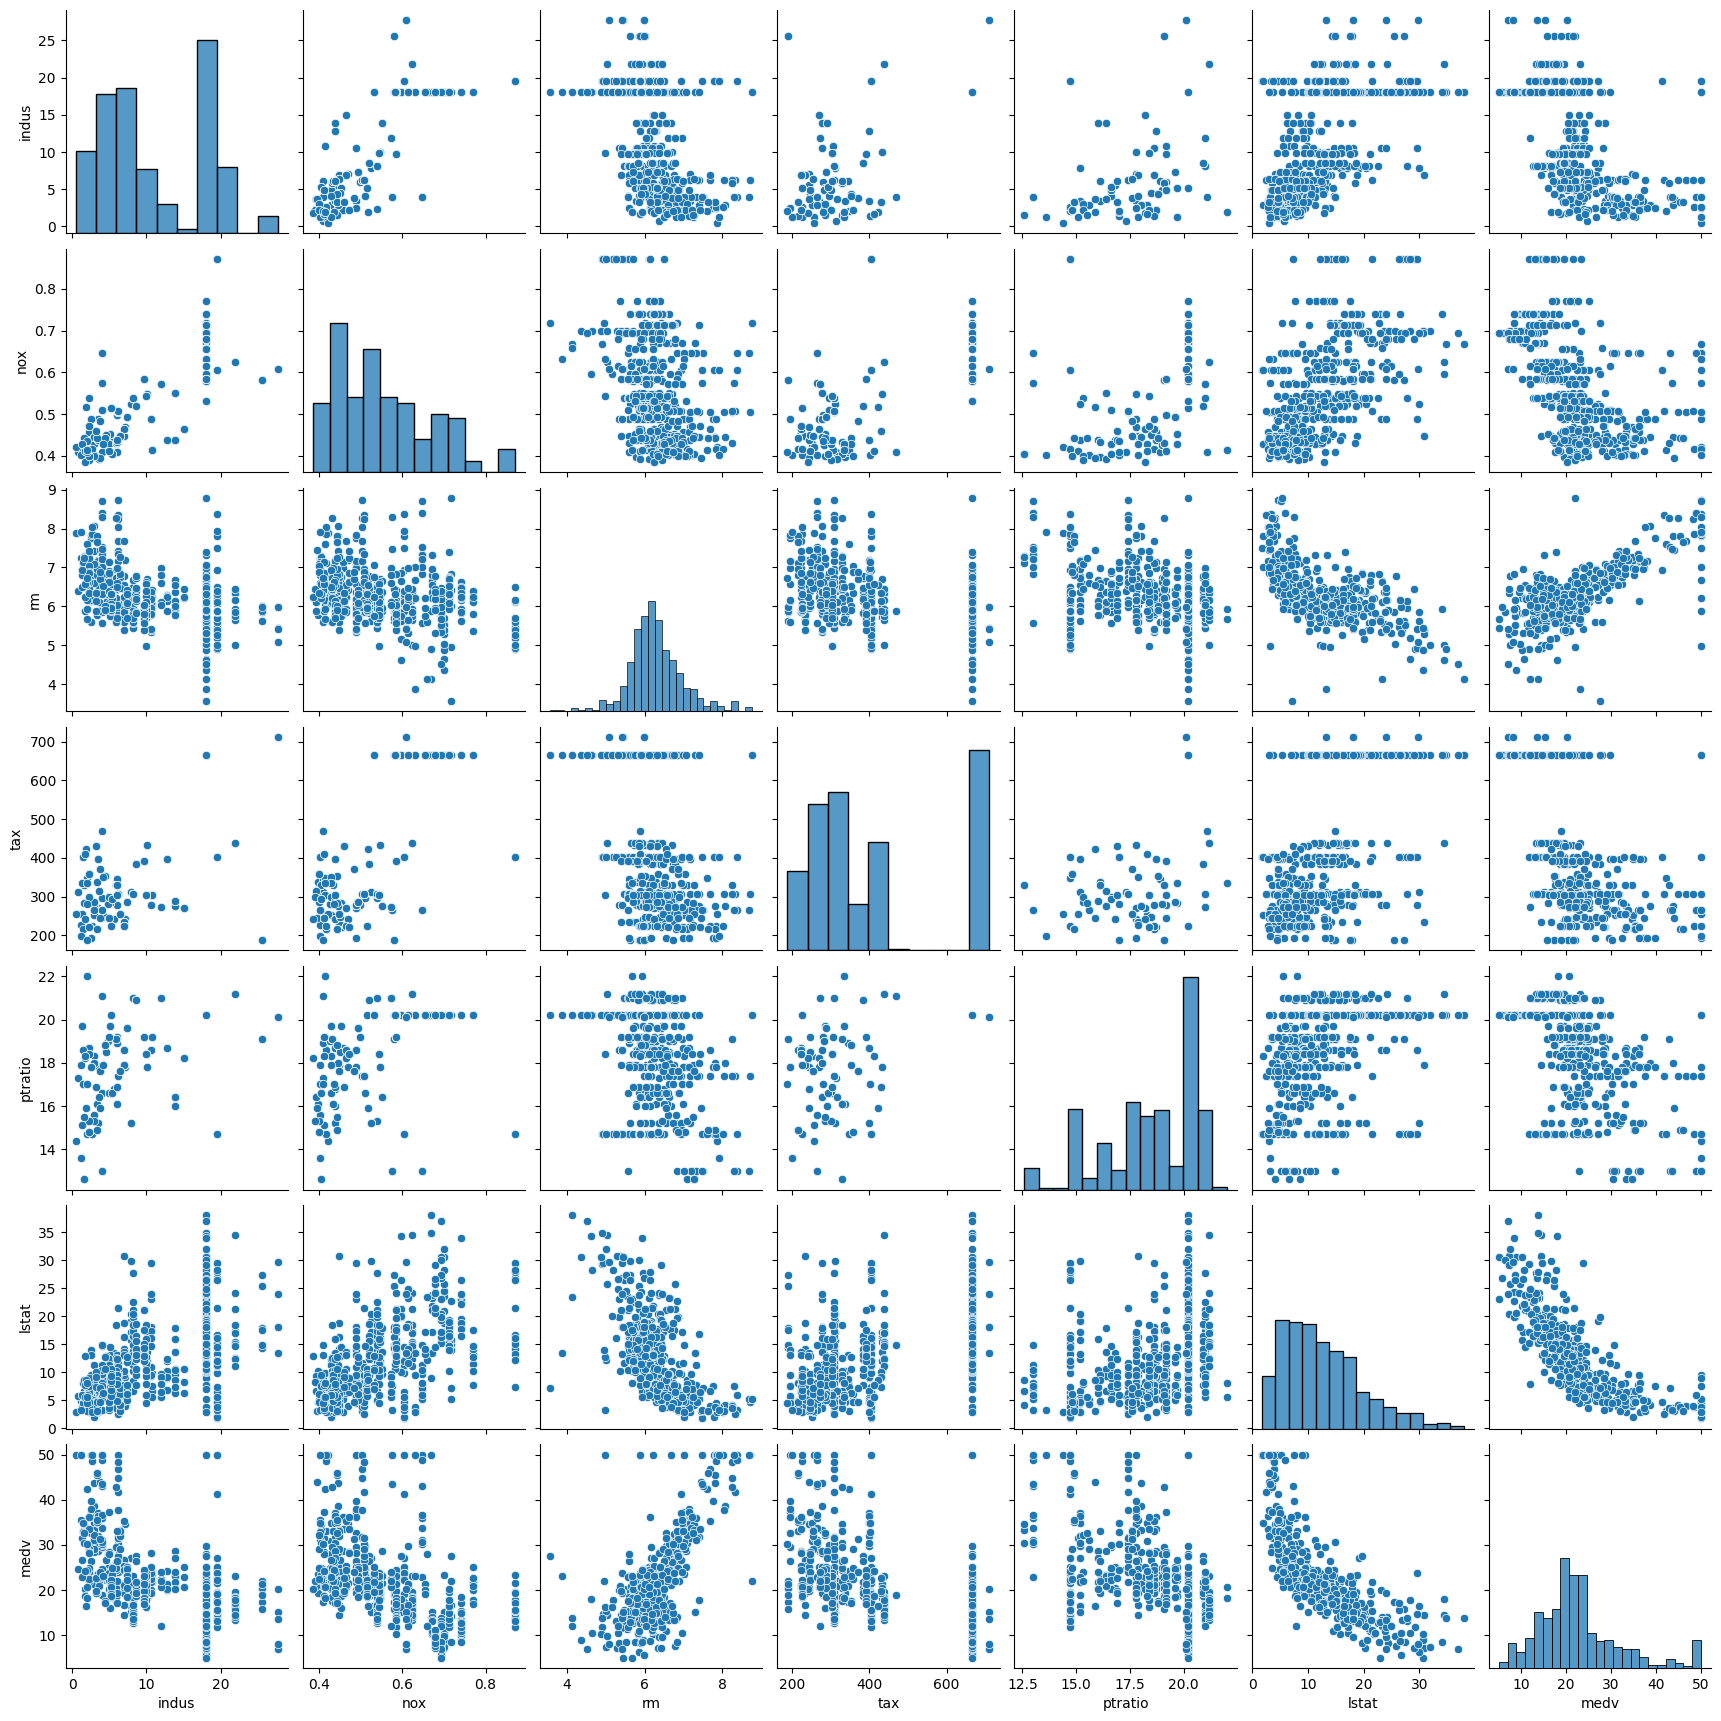

In [7]:
# pairplot to identify categorical variables, colinearity, and distributions
sns.pairplot(df_filtered)

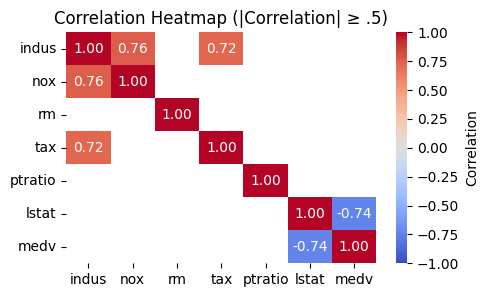

In [8]:
# Calculate correlation matrix
corr = df_filtered.corr()

# Create a mask for correlations with absolute value less than 0.5
mask = (abs(corr) < 0.7)

# Plot heatmap with the mask
plt.figure(figsize=(5, 3))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap (|Correlation| ≥ .5)");

# Data pre-processing and Feature Engineering

### Create interaction terms
After some experimentation, I created an interaction term and centered the variables involved to avoid a high Variance Inflation Factor (VIF). Centering helps reduce collinearity between the individual variables and their interaction term, which in turn improves model stability:

In [9]:
df_processed = df.copy()

# Specify interaction pairs as tuples in a list
interaction_pairs = [('rm', 'tax')]

# Center variables and create interaction terms.
# Centering before interacting to avoin high Variance Inflation Factor (VIF)
for var1, var2 in interaction_pairs:
    # Center variables
    df_processed[f'{var1}_centered'] = df_processed[var1] - df_processed[var1].mean()
    df_processed[f'{var2}_centered'] = df_processed[var2] - df_processed[var2].mean()
    
    # Create interaction term
    interaction_name = f'interaction_{var1}_{var2}'
    df_processed.loc[:, interaction_name] = df_processed[f'{var1}_centered'] * df_processed[f'{var2}_centered']

    # Drop original column
    df_processed.drop(columns=[var1, var2], inplace= True)
    
# Show results
df_processed.head(2)

,crim,zn,indus,chas,nox,age,dis,rad,ptratio,lstat,medv,rm_centered,tax_centered,interaction_rm_tax
0,0.00632,18.0,2.31,0,0.538,65.2,4.0900,1,15.3,4.98,24.0,0.290366,-112.237154,-32.589810
1,0.02731,0.0,7.07,0,0.469,78.9,4.9671,2,17.8,9.14,21.6,0.136366,-166.237154,-22.669031


### One-hot encoding
The following code performs one-hot encoding on a list of categorical variables. In this case, we haven't selected any, but the code is included as a reusable template for different use cases where categorical variables may be present:

In [10]:
# Dummy variable
categorical_columns = []
df_processed = pd.get_dummies(data = df_processed, #prefix = 'OHE', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
               dtype='int8')
df_processed.head(3)

,crim,zn,indus,chas,nox,age,dis,rad,ptratio,lstat,medv,rm_centered,tax_centered,interaction_rm_tax
0,0.00632,18.0,2.31,0,0.538,65.2,4.0900,1,15.3,4.98,24.0,0.290366,-112.237154,-32.589810
1,0.02731,0.0,7.07,0,0.469,78.9,4.9671,2,17.8,9.14,21.6,0.136366,-166.237154,-22.669031
2,0.02729,0.0,7.07,0,0.469,61.1,4.9671,2,17.8,4.03,34.7,0.900366,-166.237154,-149.674217


### Transformation and scaling
Transforming some columns using the log function. Applying a log transformation can normalize the distribution, making linear regression assumptions more valid:

In [11]:
df_processed_scaled = df_processed.copy()

# List of columns to transform with log function
columns_to_log_transform = ['lstat']

# # Apply log transformation
df_processed_scaled[columns_to_log_transform] = np.log(df_processed_scaled[columns_to_log_transform])

# Apply min-max scaling
scaler = MinMaxScaler()
df_processed_scaled = pd.DataFrame(scaler.fit_transform(df_processed_scaled), columns=df_processed_scaled.columns)
df_processed_scaled.head(2)

,crim,zn,indus,chas,nox,age,dis,rad,ptratio,lstat,medv,rm_centered,tax_centered,interaction_rm_tax
0,0.000000,0.18,0.067815,0.0,0.314815,0.641607,0.269203,0.000000,0.287234,0.342318,0.422222,0.577505,0.208015,0.497643
1,0.000236,0.00,0.242302,0.0,0.172840,0.782698,0.348962,0.043478,0.553191,0.538917,0.368889,0.547998,0.104962,0.505018


### Split data into training and testing sets

In [12]:
# Columns to drop based on p-value and VIF (form Checking Model Assumptions section)
columns_to_drop = ['age', 'rad', 'dis', 'indus']


# Separate dependent variable
X = df_processed_scaled.drop('medv',axis=1) # Independet variable
y = df_processed_scaled['medv'] # dependent variable

# Drop columns based on p-value
X = X.drop(columns=columns_to_drop)
y= y.drop(columns=columns_to_drop)

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=23)

# Model building

Define a function for model evaluation:

In [13]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model using the test data
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("MSE:", mse)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    r2 = r2_score(y_test, y_pred)
    print("R2:", r2)

    # Plot predicted vs actual
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Housing Prices y_pred')
    # overlay the regression line
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.show()

## Model 1: Linear Regression

### Train the model and assess the statistical significance of the predictors (p-values)

In [14]:
# sklearn model
model = LinearRegression()
model.fit(X_train, y_train); # x_0 =1 is no need to add, sklearn will take care of it.

# OLS model
model_OLS = sm.OLS(y_train, X_train)
results = model_OLS.fit()
print('Intercept:', model.intercept_)
summarize(results)

Intercept: 0.8458047641841202


,coef,std err,t,P>|t|
crim,-0.3004,0.088,-3.419,0.001
zn,0.0601,0.033,1.797,0.073
chas,0.1043,0.024,4.288,0.000
nox,0.0512,0.045,1.142,0.254
ptratio,0.0166,0.034,0.491,0.624
lstat,-0.1838,0.047,-3.919,0.000
rm_centered,1.0415,0.047,21.959,0.000
tax_centered,-0.0376,0.034,-1.099,0.273
interaction_rm_tax,-0.1288,0.075,-1.718,0.087


### Is there a relationship between the response and predictors? (F-statistic)

In [15]:
f_statistic = results.fvalue
print(f"F-statistic: {f_statistic:.2f}")
print('Largly greater than 1, which means at least one of the predictor has a relationship with the dependant variable')

F-statistic: 506.17
Largly greater than 1, which means at least one of the predictor has a relationship with the dependant variable


### Assess the the accurecy of the model

MSE: 0.00895018869033635
RMSE: 0.09460543689628176
R2: 0.7773594593753385


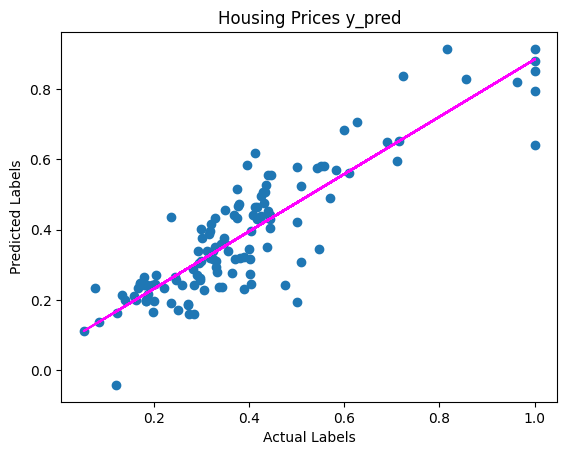

In [16]:
evaluate_model(model, X_test, y_test)

### Variance Inflation Factor (VIF)

In [17]:
# Multicollinearity: Identify high multicorrelation using VIF.

# Add intercept (statsmodels' VIF requires intercept)
X_train_with_intercept = sm.add_constant(X_train) 

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_with_intercept.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_with_intercept.values, i) 
                   for i in range(X_train_with_intercept.shape[1])]

vif_data

,Feature,VIF
0,const,117.474656
1,crim,1.710617
2,zn,1.715857
3,chas,1.060740
4,nox,2.874079
5,ptratio,1.689230
6,lstat,2.946172
7,rm_centered,2.008747
8,tax_centered,3.009233
9,interaction_rm_tax,1.233214


Variance Inflation Factor (VIF) is reasonably small for all predictors (less than 5), which means there is no multicollinearity between the variabls

## Model 2: Random Forest Regressor

RandomForestRegressor() 

MSE: 0.006677836026052301
RMSE: 0.08171802754626607
R2: 0.8338853990141684


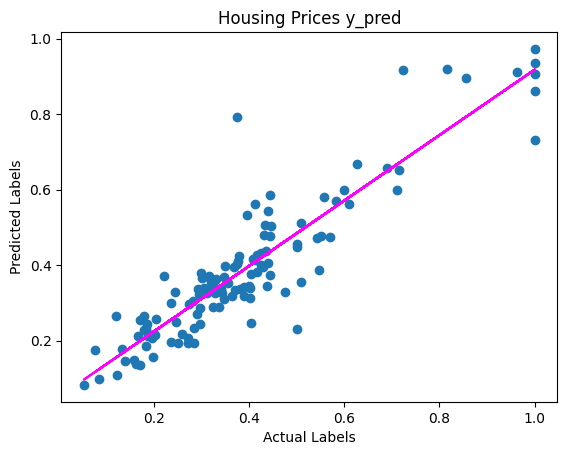

In [18]:
# Train the model
model = RandomForestRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
evaluate_model(model, X_test, y_test)

## Model 3: Gradient Boosting Regressor

Let's try using a grid search approach to try combinations from a grid of possible values for the learning_rate and n_estimators hyperparameters of the GradientBoostingRegressor estimator.

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 100} 

GradientBoostingRegressor() 

MSE: 0.00689111688998474
RMSE: 0.08301275136980306
R2: 0.8285799279795651


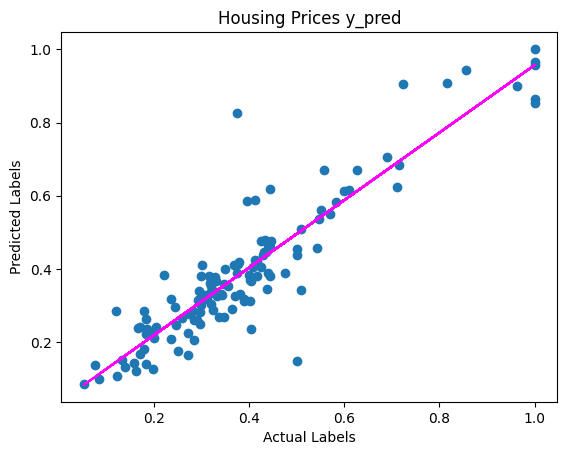

In [19]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
evaluate_model(model, X_test, y_test)


# Conclusion

After experimenting with three regression models, both the Random Forest and Gradient Boosting Regressors produced the best results. The Random Forest Regressor explained 83.4% of the variance, with an average error of $82. Plotting the predicted vs. actual values reveals a clear linear relationship with no unusual patterns, indicating a good model fit.